In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from astropy.nddata import CCDData
import astropy.constants as const
from astropy.wcs import FITSFixedWarning
import warnings
warnings.simplefilter("ignore", category=FITSFixedWarning)
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
from scipy.io import readsav
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian

In [2]:
green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_green_df_cut = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,46,38)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_green_df_cut.sort_values(by="date-obs")
totality_green_df_cut = totality_green_df_cut.reset_index(drop=True)

totality_green_df_ext = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,8))]
totality_green_df_ext.sort_values(by="date-obs")                                        
totality_green_df_ext = totality_green_df_ext.reset_index(drop=True)

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

totality_red_df_cut = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,46,40)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_red_df_cut.sort_values(by="date-obs")
totality_red_df_cut = totality_red_df_cut.reset_index(drop=True)

totality_red_df_ext = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,2))]
totality_red_df_ext.sort_values(by="date-obs")
totality_red_df_ext = totality_red_df_ext.reset_index(drop=True)

In [3]:
FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center_FeXI = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
FeXI_line_cont_xslice = slice(372-300,372+301)
FeXI_line_cont_yslice = slice(383-220,383+221)
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center_FeXI[0] - FeXI_line_cont_xslice.start, sun_center_FeXI[1] - FeXI_line_cont_yslice.start)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)


FeXIV_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIVLine_ContRatio.fits",unit="adu")
FeXIV_line_cont_image = FeXIV_line_cont_frame.data
sun_center_FeXIV = (np.float64(FeXIV_line_cont_frame.header["SUNX"]),np.float64(FeXIV_line_cont_frame.header["SUNY"]))
FeXIV_line_cont_xslice = slice(372-300,372+301)
FeXIV_line_cont_yslice = slice(383-220,383+221)
FeXIV_line_cont_cutout = FeXIV_line_cont_image[FeXIV_line_cont_yslice, FeXIV_line_cont_xslice]
FeXIV_rotate_center = (sun_center_FeXIV[0] - FeXIV_line_cont_xslice.start, sun_center_FeXIV[1] - FeXIV_line_cont_yslice.start)
FeXIV_line_cont_image_rot_scipy = ndimage.rotate(FeXIV_line_cont_cutout, angle=360 - np.float64(FeXIV_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

In [56]:
Te_diag_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIV_FeXITemperature.fits",unit="adu")
Te_diag_image = Te_diag_frame.data
sun_center_Te_diag = (np.float64(Te_diag_frame.header["SUNX"]),np.float64(Te_diag_frame.header["SUNY"]))
Te_diag_xslice = slice(372-300,372+301)
Te_diag_yslice = slice(383-220,383+221)
Te_diag_cutout = Te_diag_image[Te_diag_yslice, Te_diag_xslice]
Te_diag_rotate_center = (sun_center_Te_diag[0] - Te_diag_xslice.start, sun_center_Te_diag[1] - Te_diag_yslice.start)
Te_diag_image_rot_scipy = ndimage.rotate(Te_diag_cutout, angle=360 - np.float64(Te_diag_frame.header["SUNROT"]),reshape=False,order=1)

In [4]:
with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos_linear_fit.h5", 'r') as hf:
    sun_x_fitparam = hf['sun_x_fitparam'][:]
    sun_y_fitparam = hf['sun_y_fitparam'][:]

sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

In [5]:
slit_pos = 209.4
rsun_arcsec = 950.0
rsun_context_pixel = 71.4
pixel_ratio = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])
img_pixel_to_arcsec = np.float64(FeXI_line_cont_frame.header["SUNR"])/rsun_arcsec
pixel_ratio_to_arcsec = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])*img_pixel_to_arcsec
rotate_angle_context = -27.5

eis_idl_sav = readsav("../../sav/EIS/EQSPY/EQSPY_lvl1_offset_170821_tilt_cor.sav",verbose=False)
eis_eqs_xcen, eis_eqs_ycen = np.array((eis_idl_sav["xcen"], eis_idl_sav["ycen_195"])) + eis_idl_sav["xy_correct_aia"]
eis_eqs_fovx, eis_eqs_fovy = np.array((eis_idl_sav["fovx"], eis_idl_sav["fovy"]))
eis_eqs_xstart = eis_eqs_xcen - eis_eqs_fovx/2.
eis_eqs_xend = eis_eqs_xcen + eis_eqs_fovx/2.
eis_eqs_ystart = eis_eqs_ycen - eis_eqs_fovy/2.
eis_eqs_yend = eis_eqs_ycen + eis_eqs_fovy/2.

In [6]:
green_frame_wavelength = CCDData.read(os.path.join(green_path,totality_green_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data

In [8]:
green_limb_loc = np.array([396.,625.,])
x_1d_grid_green_ext = np.arange(-63,125,1,dtype=np.float64)
y_1d_grid_green_ext = np.arange(np.mean(green_limb_loc) - 699.,  np.mean(green_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_green_arcsec_ext = y_1d_grid_green_ext/(np.diff(green_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_green_arcsec_ext = x_1d_grid_green_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_green_arcsec_bin_ext = np.average(y_1d_grid_green_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_green_arcsec_ext, y_2d_grid_green_arcsec_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_ext)
x_2d_grid_green_arcsec_bin_ext, y_2d_grid_green_arcsec_bin_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_bin_ext)

y_green_step_correction_ext = (sun_y_fitpoly(np.linspace(0,93.5,188)) - sun_y_fitpoly(62))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_green_step_correction_ext = np.flip(y_green_step_correction_ext)

y_2d_grid_green_arcsec_correct_ext = y_2d_grid_green_arcsec_ext + y_green_step_correction_ext[np.newaxis,:]
y_2d_grid_green_arcsec_bin_correct_ext = y_2d_grid_green_arcsec_bin_ext + y_green_step_correction_ext[np.newaxis,:]

x_2d_grid_green_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

y_2d_grid_green_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

x_2d_grid_green_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

y_2d_grid_green_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

In [11]:
img_center = np.array([300,220])

def func_img_xpixel_to_xarcsec(x):
    return (x - img_center[0])/img_pixel_to_arcsec

def func_img_xarcsec_to_xpixel(x):
    return x*img_pixel_to_arcsec + img_center[0]

def func_img_ypixel_to_yarcsec(x):
    return (x - img_center[1])/img_pixel_to_arcsec

def func_img_yarcsec_to_ypixel(x):
    return x*img_pixel_to_arcsec + img_center[1]

def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

def find_nearest_pixel(x,y,x_grid,y_grid):
    distance = np.sqrt((x - x_grid)**2 + (y - y_grid)**2)
    index = np.unravel_index(np.argmin(distance),distance.shape)
    return index

In [9]:
FeXIV_63rd_xslice = slice(345,395)
pixel_size_green = np.abs(np.mean(np.diff((green_frame_wavelength/63./10.)[FeXIV_63rd_xslice])))
inst_width_pix_green = 1.86
inst_width_nm_green = pixel_size_green*inst_width_pix_green

print(pixel_size_green, inst_width_nm_green)

0.024135148361387 0.04489137595217982


In [12]:
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

In [22]:
def get_green_fit_int_vlos_veff(filename, xslice, order):
    with h5py.File(filename, 'r') as hf:
        green_fit_matrix_ext = hf['green_fit_matrix_ext'][:]
        green_fit_matrix_ext_err = hf['green_fit_matrix_ext_err'][:]
        green_fit_matrix_bin_ext = hf['green_fit_matrix_bin_ext'][:]
        green_fit_matrix_bin_ext_err = hf['green_fit_matrix_bin_ext_err'][:]
        green_fit_filename_index = hf['green_fit_filename_index'][:]
        green_fit_filename_index = hf['green_fit_filename_index'][:]
    
    pixel_size_green = np.abs(np.mean(np.diff((green_frame_wavelength/order/10.)[xslice])))
    inst_width_pix_green = 1.86
    inst_width_nm_green = pixel_size_green*inst_width_pix_green

    green_where_disk_ext = np.where((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)**2 + \
                                        (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)**2 < 940**2)

    green_line_int_masked = np.copy(green_fit_matrix_ext[1,:,:])
    green_line_int_masked[green_where_disk_ext] = np.nan

    green_where_disk_bin_ext = np.where((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green)**2 + \
                                        (y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)**2 < 940**2)

    green_vlos_masked = -(np.copy(green_fit_matrix_bin_ext[0,:,:]) - 530.29)/530.29*const.c.cgs.value*1e-5
    green_vlos_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
    green_vlos_masked[green_where_disk_bin_ext] = np.nan
    green_vlos_masked = green_vlos_masked - np.nanmedian(green_vlos_masked)
    green_vlos_masked_err = green_fit_matrix_bin_ext_err[0,:,:]/530.29*const.c.cgs.value*1e-5
    green_vlos_masked_err[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
    green_vlos_masked_err[green_where_disk_bin_ext] = np.nan

    green_fwhm_masked = np.copy(green_fit_matrix_bin_ext[2,:,:])
    green_fwhm_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
    green_fwhm_masked[green_where_disk_bin_ext] = np.nan
    green_fwhm_masked_err = np.copy(green_fit_matrix_bin_ext_err[2,:,:])
    green_fwhm_masked_err[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
    green_fwhm_masked_err[green_where_disk_bin_ext] = np.nan        
    green_veff_masked = np.sqrt(green_fwhm_masked**2 - inst_width_nm_green**2)/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
    green_veff_masked_err = green_fwhm_masked/np.sqrt(green_fwhm_masked**2 - inst_width_nm_green**2)* \
        green_fwhm_masked_err/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))


    return green_line_int_masked, green_vlos_masked, green_veff_masked

In [23]:
FeXIV_63rd_int, FeXIV_63rd_vlos, FeXIV_63rd_veff = get_green_fit_int_vlos_veff("../../sav/Eclipse/FitResults/FeXIV_63.h5", slice(345,395), 63)
FeXIV_62nd_int, FeXIV_62nd_vlos, FeXIV_62nd_veff = get_green_fit_int_vlos_veff("../../sav/Eclipse/FitResults/FeXIV_62.h5", slice(680,730), 62)
FeXIV_61st_int, FeXIV_61st_vlos, FeXIV_61st_veff = get_green_fit_int_vlos_veff("../../sav/Eclipse/FitResults/FeXIV_61.h5", slice(1010,1060), 61)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt


In [48]:
FeXIV_aver_int = np.nanmean(np.stack((FeXIV_61st_int,FeXIV_62nd_int,FeXIV_63rd_int)),axis=0)
FeXIV_aver_vlos = np.nanmean(np.stack((FeXIV_61st_vlos,FeXIV_62nd_vlos,FeXIV_63rd_vlos)),axis=0)
FeXIV_aver_veff = np.nanmean(np.stack((FeXIV_61st_veff,FeXIV_62nd_veff,FeXIV_63rd_veff)),axis=0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
FeXIV_std_int = np.nanstd(np.stack((FeXIV_61st_int,FeXIV_62nd_int,FeXIV_63rd_int)),axis=0)
FeXIV_std_vlos = np.nanstd(np.stack((FeXIV_61st_vlos,FeXIV_62nd_vlos,FeXIV_63rd_vlos)),axis=0)
FeXIV_std_veff = np.nanstd(np.stack((FeXIV_61st_veff,FeXIV_62nd_veff,FeXIV_63rd_veff)),axis=0)

/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [50]:
def create_rec_eqs():
    return patches.Rectangle((eis_eqs_xstart, eis_eqs_ystart),
                            eis_eqs_fovx, eis_eqs_fovy,linewidth=2,edgecolor="red",
                            facecolor="none",alpha=0.6)

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                            facecolor="none",alpha=0.6,ls="--")

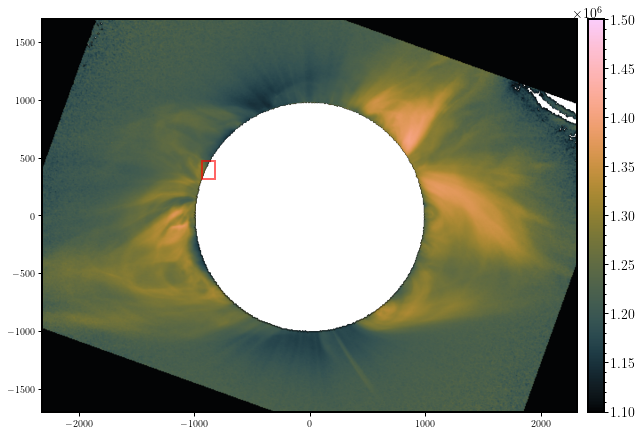

In [71]:
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)

im_te = ax.pcolormesh(img_xarcsec_array,img_yarcsec_array,Te_diag_image_rot_scipy,vmin=1.1e6,vmax=1.5e6,
                    cmap=cmcm.batlowK,shading="gouraud",rasterized=True)
ax.add_patch(create_rec_eqs())
plot_colorbar(im_te,ax)
ax.set_aspect(1)

In [62]:
img_yarcsec_mesh, img_xarcsec_mesh = np.meshgrid(img_yarcsec_array,img_xarcsec_array,indexing="ij")

In [63]:
where_in_eis_fov = np.where((img_xarcsec_mesh < eis_eqs_xend) & (img_xarcsec_mesh > eis_eqs_xstart) & \
                (img_yarcsec_mesh < eis_eqs_yend) &  (img_yarcsec_mesh > eis_eqs_ystart))

In [67]:
np.log10(np.nanmean(Te_diag_image_rot_scipy[where_in_eis_fov]))

6.100617659471078

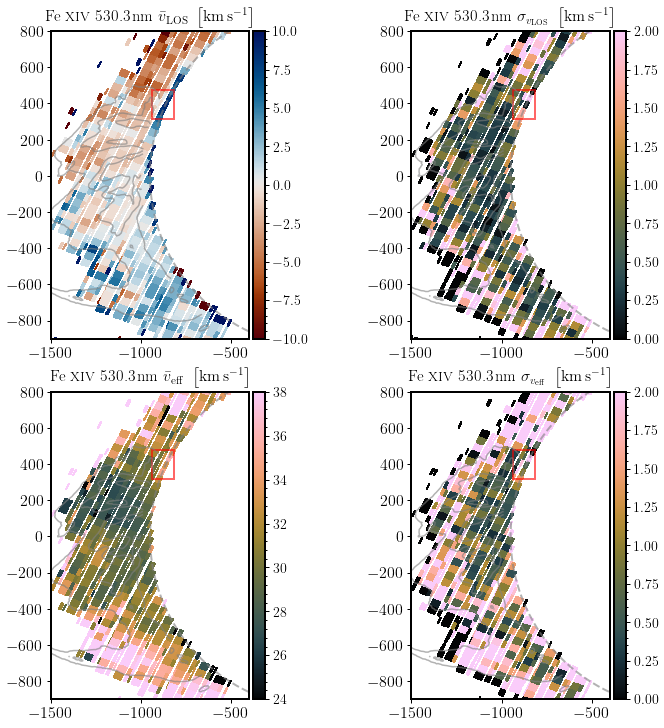

In [54]:
colorbar_width = "6%"
fig, axes = plt.subplots(2,2,figsize=(10,10),constrained_layout=True)

im_aver_vlos = axes[0,0].pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                FeXIV_aver_vlos,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10
                )
axes[0,0].set_title(r"Fe \textsc{xiv} 530.3\,nm $\bar{v}_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)

plot_colorbar(im_aver_vlos, axes[0,0],width=colorbar_width)

im_std_vlos = axes[0,1].pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                FeXIV_std_vlos,cmap=cmcm.batlowK,rasterized=True,vmax=2,
                )
plot_colorbar(im_std_vlos, axes[0,1],width=colorbar_width)
axes[0,1].set_title(r"Fe \textsc{xiv} 530.3\,nm $\sigma_{v_{\rm LOS}}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)

im_aver_veff = axes[1,0].pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                FeXIV_aver_veff,cmap=cmcm.batlowK,rasterized=True,vmin=24,vmax=38,
                )
plot_colorbar(im_aver_veff, axes[1,0],width=colorbar_width)

axes[1,0].set_title(r"Fe \textsc{xiv} 530.3\,nm $\bar{v}_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)

im_std_veff = axes[1,1].pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                FeXIV_std_veff,cmap=cmcm.batlowK,rasterized=True,vmax=2,
                )

plot_colorbar(im_std_vlos, axes[1,1],width=colorbar_width)
axes[1,1].set_title(r"Fe \textsc{xiv} 530.3\,nm $\sigma_{v_{\rm eff}}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)

xlim_zoomin = [-1500,-400]
ylim_zoomin = [-900,800]

for ax_ in axes.flatten():
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.4,0.65,0.9],alpha=0.6,
            colors=['grey'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=16)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)


In [52]:
red_frame_wavelength = CCDData.read(os.path.join(red_path,totality_red_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data

with h5py.File("../../sav/Eclipse/FitResults/FeX_52.h5", 'r') as hf:
    red_fit_matrix_ext = hf['red_fit_matrix_ext'][:]
    red_fit_matrix_ext_err = hf['red_fit_matrix_ext_err'][:]
    red_fit_matrix_bin_ext = hf['red_fit_matrix_bin_ext'][:]
    red_fit_matrix_bin_ext_err = hf['red_fit_matrix_bin_ext_err'][:]
    red_fit_filename_index = hf['red_fit_filename_index'][:]
    red_fit_filename_index = hf['red_fit_filename_index'][:]

In [55]:
np.diff(y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)

array([[-2.53811259, -2.53811259, -2.53811259, ..., -2.53811259,
        -2.53811259, -2.53811259],
       [-2.53811259, -2.53811259, -2.53811259, ..., -2.53811259,
        -2.53811259, -2.53811259],
       [-2.53811259, -2.53811259, -2.53811259, ..., -2.53811259,
        -2.53811259, -2.53811259],
       ...,
       [-2.53811259, -2.53811259, -2.53811259, ..., -2.53811259,
        -2.53811259, -2.53811259],
       [-2.53811259, -2.53811259, -2.53811259, ..., -2.53811259,
        -2.53811259, -2.53811259],
       [-2.53811259, -2.53811259, -2.53811259, ..., -2.53811259,
        -2.53811259, -2.53811259]])